In [2]:
import sys
sys.path.append('/Users/cauaveiga/Documents/ENGENHARIA FÍSICA/3º ANO/2º Semestre/Métodos Computacionais')
import pde as pde

import numpy as np
import matplotlib.pyplot as plt
import timeit



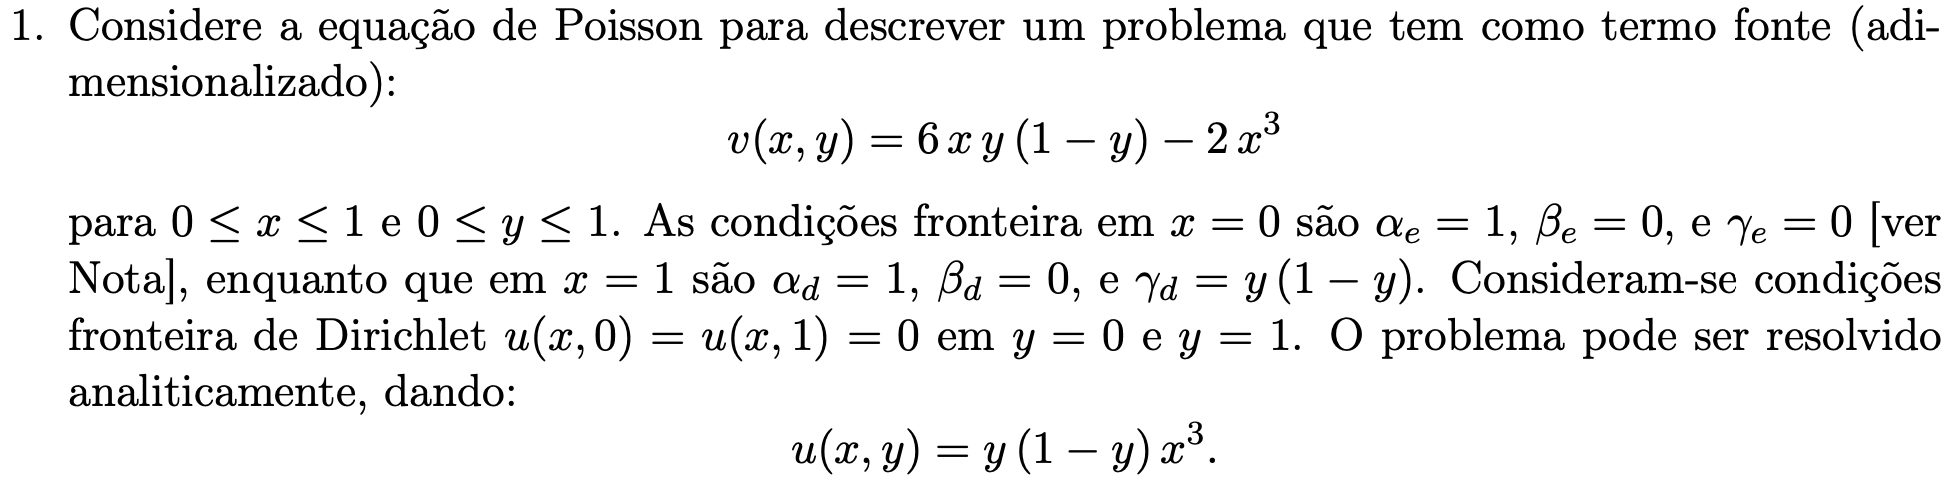

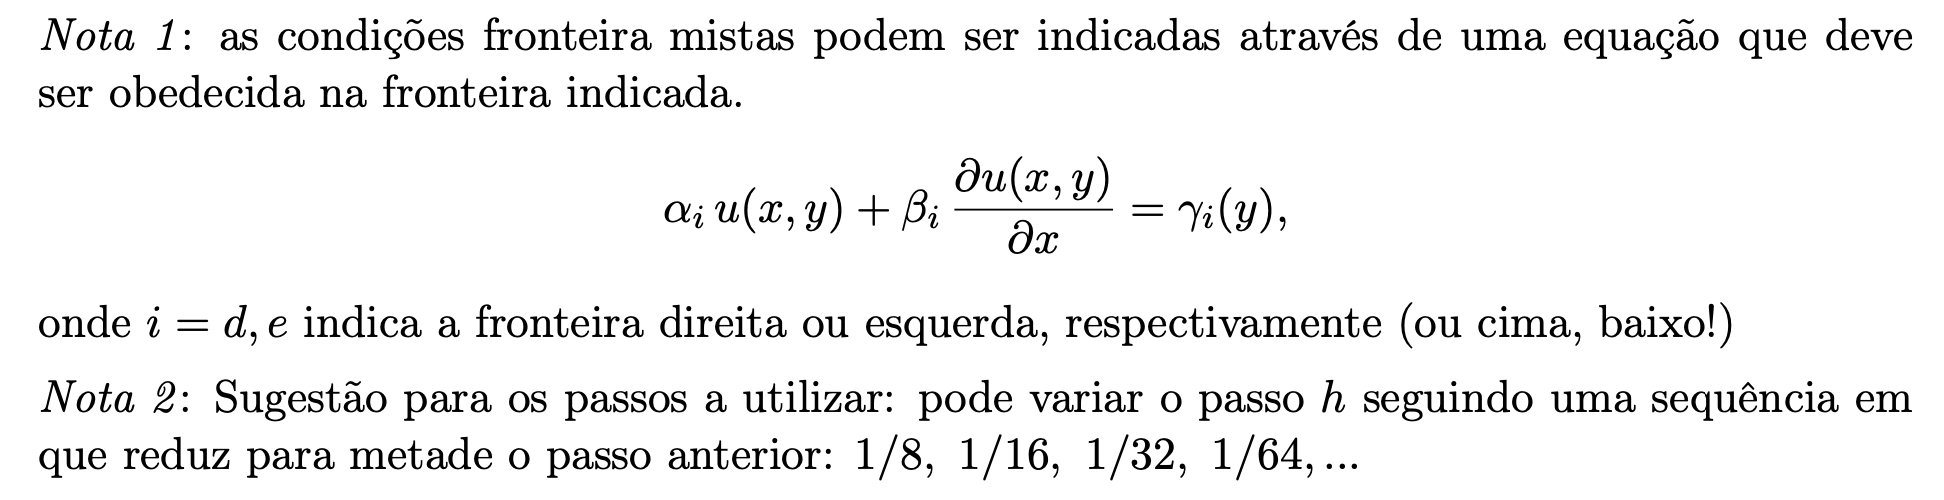

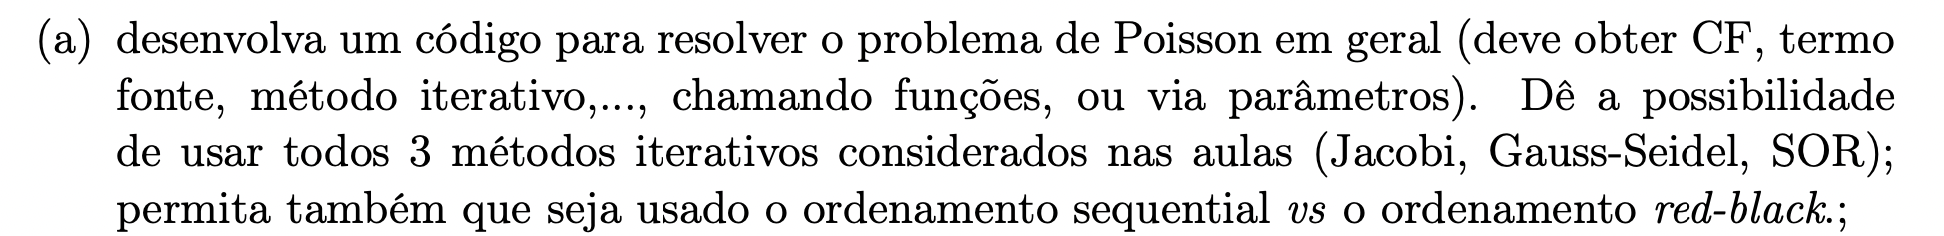

**TODOS OS MÉTODOS ESTÃO IMPLEMENTADOS NO ARQUIVO PDE.PY, NA PASTA 'MÉTODOS COMPUTACIONAIS' (AINDA SEM O ORDENAMENTO RED-BLACK)**

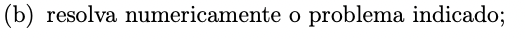

Primeiramente começamos por verificar a resolução analítica:

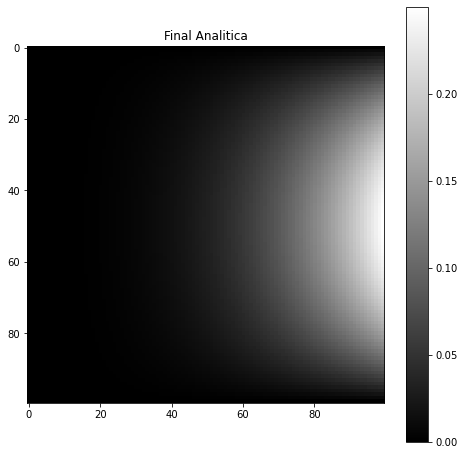

In [3]:
def anal(x,y):
    return y*(1-y)*x**3


x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
X,Y = np.meshgrid(x,y)
final = anal(X,Y)


plt.figure(figsize=(8,8))
plt.title('Final Analitica')
plt.imshow(final,cmap='gray')
plt.colorbar()
plt.show()

Em seguida vamos definir a grid 'inicial', ou seja, com o termo fonte e as condições de fronteira

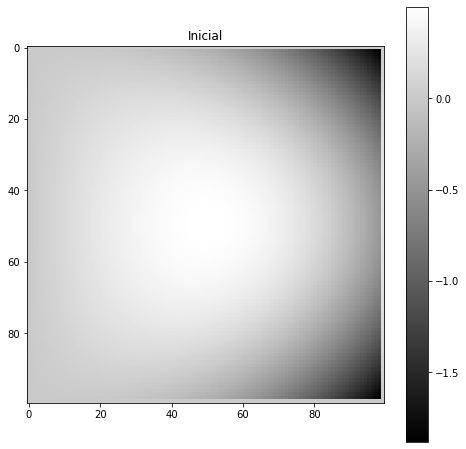

In [3]:
def fonte(x,y):
    return 6*x*y*(1-y)-2*x**3

# Parâmetros
nx = 200 #COLUNAS
ny = 200 #LINHAS
xmin = 0
xmax = 1
ymin = 0
ymax = 1

dx = (xmax - xmin) / (nx - 1)
dy = (ymax - ymin) / (ny - 1)

# Inicialização
x  = np.linspace(xmin, xmax, nx)
y  = np.linspace(xmin, xmax, ny)
X,Y = np.meshgrid(x,y)
grid = fonte(X,Y)


grid[0,:] = grid[-1,:] = 0
grid[:,0] = 0
grid[:,-1] = Y[:,-1]*(1-Y[:,0])

plt.figure(figsize=(8,8))
plt.title('Inicial')
plt.imshow(grid,cmap='gray')
plt.colorbar()
plt.show()


In [30]:
dx

0.010101010101010102

Vamos então resolver númericamente utilizando o método de jacobi (vetorizado)

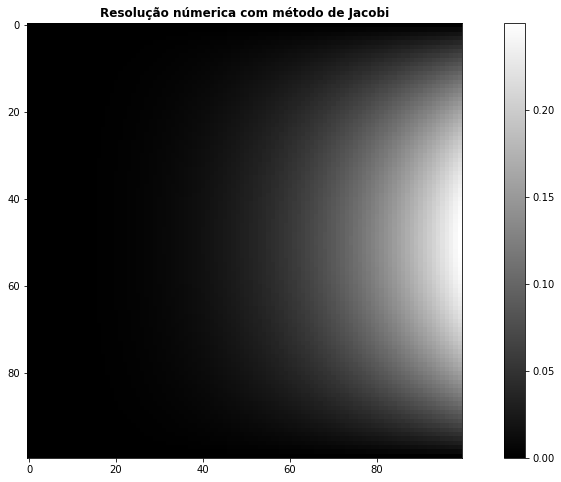

In [4]:
jac = pde.Jacobi(grid,dx,dy,target=1e-7)

plt.figure(figsize=(15,8))
plt.imshow(jac)
plt.title("Resolução númerica com método de Jacobi", fontweight="bold")
plt.gray()
plt.colorbar()
plt.show()

Podemos notar que com utilizando um target accuracy de 1e-7 a solução númerica é muito próxima da solução analítica esperada

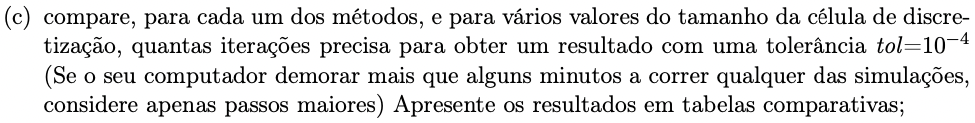

In [15]:
tamanhos = [(50,50),(100,100),(200,200)]


contagens = [[],[],[]] # 0:jacobi, 1:gauss, 2:sor

nomes = ["Jacobi","Gauss Seidel", "SOR"]

for met in range(3): # 0:jacobi, 1:gauss, 2:sor
    
    for tp in tamanhos:
        # Começamos por reconstruir o grid com o tamanho certo
        ny,nx = tp
        
        xmin = 0
        xmax = 1
        
        ymin = 0
        ymax = 1

        dx = (xmax - xmin) / (nx - 1)
        dy = (ymax - ymin) / (ny - 1)

        # Inicialização
        x  = np.linspace(xmin, xmax, nx)
        y  = np.linspace(xmin, xmax, ny)
        X,Y = np.meshgrid(x,y)
        mesh = fonte(X,Y)


        mesh[0,:] = mesh[-1,:] = 0
        mesh[:,0] = 0
        mesh[:,-1] = Y[:,-1]*(1-Y[:,0])
        
        if met==0:
            jac,ct = pde.Jacobi(mesh,dx,dy,target=1e-4,count=True)
        if met==1:
            gs,ct = pde.gsidel(mesh,dx,dy,target=1e-4,count=True)
        if met==2:
            sor,ct = pde.SOR(mesh,dx,dy,0.93,target=1e-4,count=True)
            
        contagens[met].append(ct)
    print(f" {nomes[met]} done!")

 Jacobi done!
 Gauss Seidel done!
 SOR done!


In [18]:
import pandas as pd

data = np.array(contagens)
df = pd.DataFrame(data=data, index=nomes, columns=tamanhos)

print("Tabela número de contagens pelo tamanho (ny,nx) para cada método")
df

Tabela número de contagens pelo tamanho (ny,nx) para cada método


,"(50, 50)","(100, 100)","(200, 200)"
Jacobi,884,1582,2250
Gauss Seidel,558,1165,1588
SOR,150,201,348


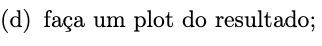

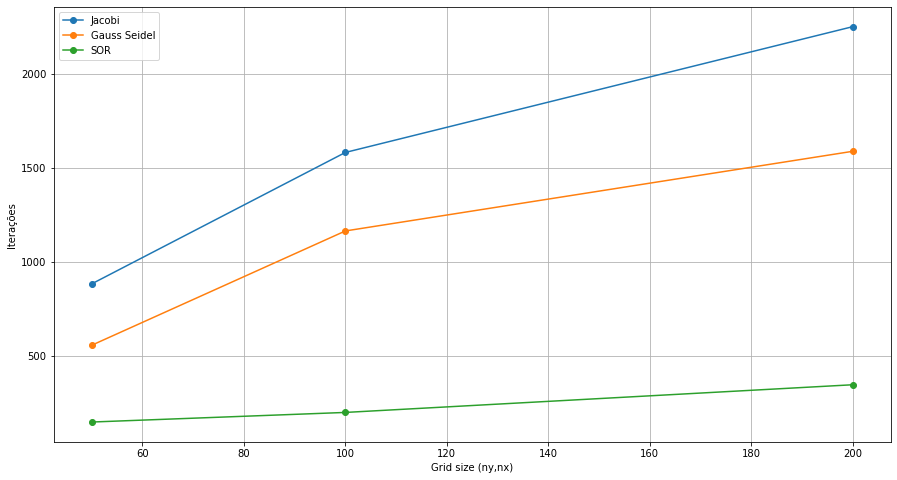

In [23]:
xx = [50,100,200]
jac_c = contagens[0]
gauss_c = contagens[1]
sor_c = contagens[2]

plt.figure(figsize=(15,8))
plt.plot(xx,jac_c,"-o",label="Jacobi")
plt.plot(xx,gauss_c,"-o",label="Gauss Seidel")
plt.plot(xx,sor_c,"-o",label="SOR")
plt.xlabel("Grid size (ny,nx)")
plt.ylabel("Iterações")
plt.grid()
plt.legend()
plt.show()

In [27]:
def sidel_rb(grid, dx, dy, target=1e-6):
    ny = grid.shape[0]
    nx = grid.shape[1]

    #Create arrays to hold potential values
    phi = grid.copy()


    # Main loop
    delta = 1.0
    while delta>target:
        phiprime = phi.copy()
        
        # Update Red-Dots
        for i in range(1,ny-1):
            if i//2!=0:
                # Lines where the first dot is red (excluding the boundaries)
                phi[i,1:-2:2]=(dy**2*(phi[i,2::2]+phi[i,0:-3:2]) + dx**2*(phi[i-1,1:-2:2]+phi[i+1,1:-2:2])
                               - grid[i,1:-2:2]*dx**2*dy**2) / (2*(dx**2+dy**2))
            
            else:
                # Lines where the first dot is black (excluding the boundaries)
                phi[i,2:-1:2]=(dy**2*(phi[i,3::2]+phi[i,1:-2:2]) + dx**2*(phi[i-1,2:-1:2]+phi[i+1,2:-1:2])
                              - grid[i,2:-1:2]*dx**2*dy**2) / (2*(dx**2+dy**2))
        
        # Update Black-Dots (using the new red-dot's values)
        for i in range(1,ny-1):
            if i//2==0:
                # Lines where the first dot is black (excluding the boundaries)
                phi[i,1:-2:2]=(dy**2*(phi[i,2::2]+phi[i,0:-3:2]) + dx**2*(phi[i-1,1:-2:2]+phi[i+1,1:-2:2])
                               - grid[i,1:-2:2]*dx**2*dy**2) / (2*(dx**2+dy**2))
            
            else:
                # Lines where the first dot is red (excluding the boundaries)
                phi[i,2:-1:2]=(dy**2*(phi[i,3::2]+phi[i,1:-2:2]) + dx**2*(phi[i-1,2:-1:2]+phi[i+1,2:-1:2])
                              - grid[i,2:-1:2]*dx**2*dy**2) / (2*(dx**2+dy**2))  
                

        # Calculate maximum difference from old values 
        delta = np.amax(abs(phi-phiprime))     

    return phi

5.41 s ± 53.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


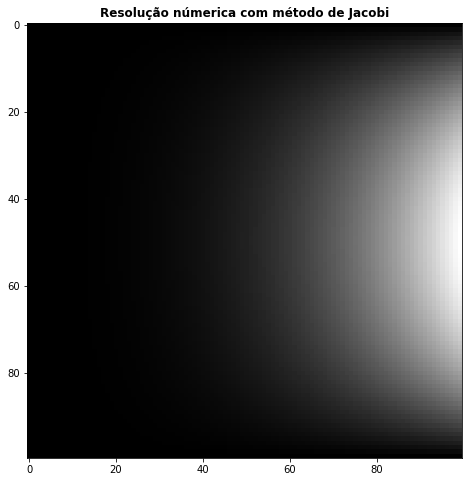

In [31]:
%timeit teste = sidel_rb(grid,dx,dy,target=1e-6)

plt.figure(figsize=(15,8))
plt.imshow(teste)
plt.title("Resolução númerica com método de Jacobi", fontweight="bold")
plt.gray()
plt.show()

In [48]:
def sidel_rb(grid, dx, dy, target=1e-6):
    ny = grid.shape[0]
    nx = grid.shape[1]

    #Create arrays to hold potential values
    phi = grid.copy()


    # Main loop
    delta = 1.0
    while delta>target:
        phiprime = phi.copy()
        
        # Update Red-Dots
        # Lines where the first dot is red (excluding the boundaries)
        phi[1:-1:2,1:-1:2]=(dy**2*(phi[1:-1:2,2::2]+phi[1:-1:2,0:-2:2]) + dx**2*(phi[0:-2:2,1:-1:2]+phi[2::2,1:-1:2])
                               - grid[1:-1:2,1:-1:2]*dx**2*dy**2) / (2*(dx**2+dy**2))
            
        # Lines where the first dot is black (excluding the boundaries)
        phi[2:-1:2,2:-1:2]=(dy**2*(phi[2:-1:2,3::2]+phi[2:-1:2,1:-2:2]) + dx**2*(phi[1:-2:2,2:-1:2]+phi[3::2,2:-1:2])
                              - grid[2:-1:2,2:-1:2]*dx**2*dy**2) / (2*(dx**2+dy**2))
        
        
        # Update Black-Dots (using the new red-dot's values)
        
        # Lines where the first dot is black (excluding the boundaries)
        phi[2:-1:2,1:-1:2]=(dy**2*(phi[2:-1:2,2::2]+phi[2:-1:2,0:-2:2]) + dx**2*(phi[1:-2:2,1:-1:2]+phi[3::2,1:-1:2])
                               - grid[2:-1:2,1:-1:2]*dx**2*dy**2) / (2*(dx**2+dy**2))
            
        
        # Lines where the first dot is red (excluding the boundaries)
        phi[1:-1:2,2:-1:2]=(dy**2*(phi[1:-1:2,3::2]+phi[1:-1:2,1:-2:2]) + dx**2*(phi[0:-2:2,2:-1:2]+phi[2::2,2:-1:2])
                              - grid[1:-1:2,2:-1:2]*dx**2*dy**2) / (2*(dx**2+dy**2))  
                

        # Calculate maximum difference from old values 
        delta = np.amax(abs(phi-phiprime))     

    return phi

712 ms ± 20.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


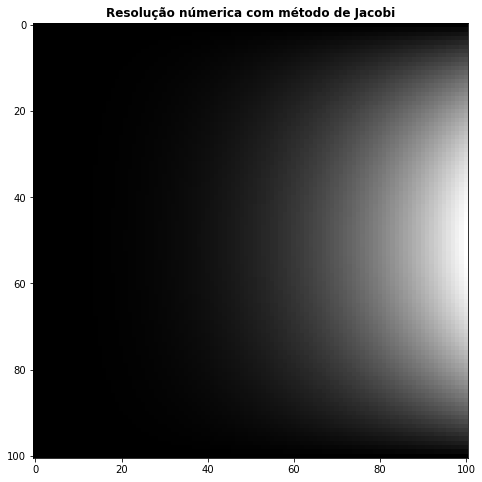

In [53]:
%timeit sidel_rb(grid,dx,dy,target=1e-6)

s_rb = sidel_rb(grid,dx,dy,target=1e-6)
plt.figure(figsize=(15,8))
plt.imshow(s_rb)
plt.title("Resolução númerica com método de Jacobi", fontweight="bold")
plt.gray()
plt.show()

19012


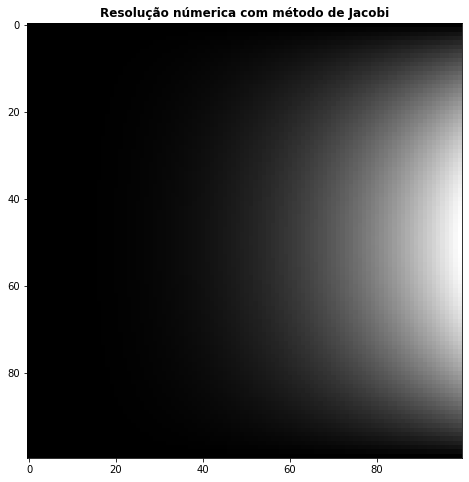

In [47]:
#%timeit pde.Jacobi(grid,dx,dy,target=1e-6)

jac,ct = pde.Jacobi(grid,dx,dy,target=1e-8,count=True)

print(ct)

plt.figure(figsize=(15,8))
plt.imshow(jac)
plt.title("Resolução númerica com método de Jacobi", fontweight="bold")
plt.gray()
plt.show()

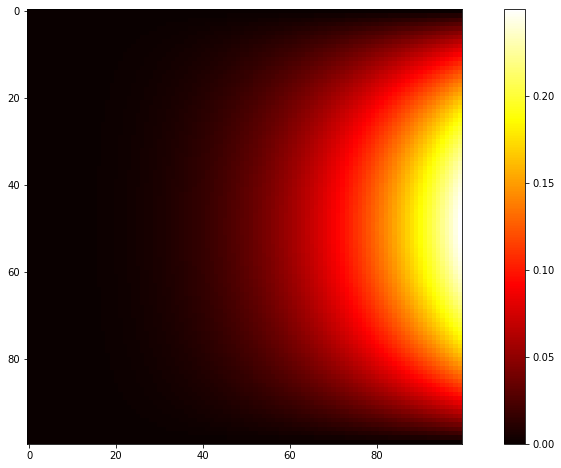

In [5]:
#%timeit pde.SOR(grid,dx,dy,0.93,target=1e-6,REDBLACK=True)

sr = pde.SOR(grid,dx,dy,0.93,target=1e-8,REDBLACK=True)

plt.figure(figsize=(15,8))
plt.imshow(sr,cmap='hot')
#plt.title("Resolução númerica com método de Jacobi", fontweight="bold")
#plt.gray()
plt.colorbar()
plt.show()

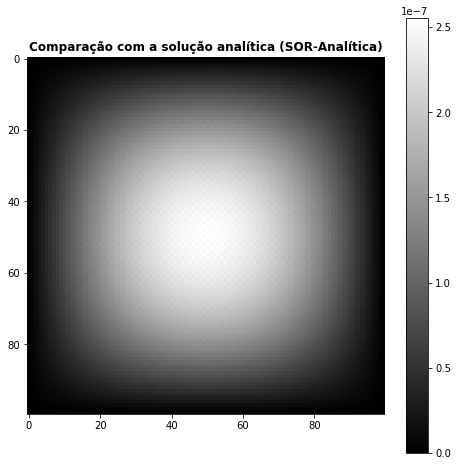

In [6]:
comp = sr-final

plt.figure(figsize=(8,8))
plt.title('Comparação com a solução analítica (SOR-Analítica)',fontweight='bold')
plt.imshow(comp)
plt.colorbar()
plt.show()




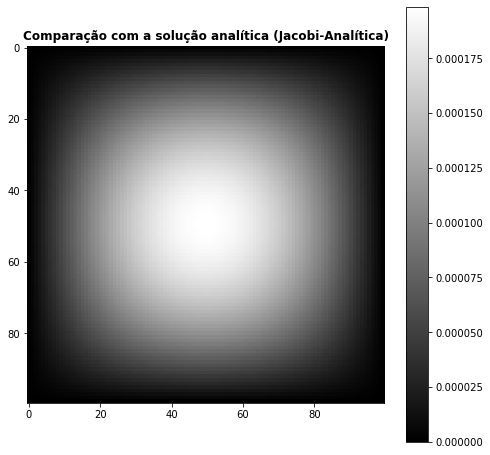

In [7]:
comp_jac = jac -final

plt.figure(figsize=(8,8))
plt.title('Comparação com a solução analítica (Jacobi-Analítica)',fontweight='bold')
plt.imshow(comp_jac)
plt.colorbar()
plt.show()



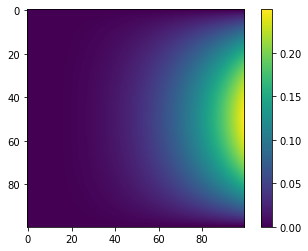

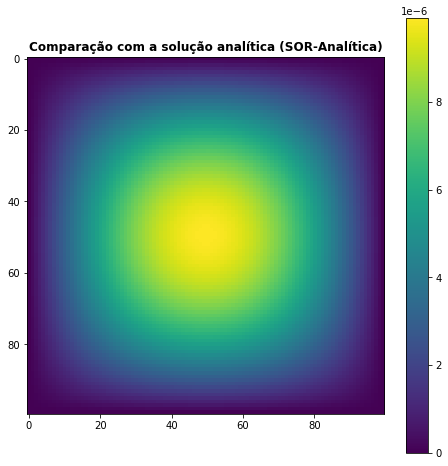

In [6]:
gs = pde.gsidel(grid,dx,dy,target=1e-8,REDBLACK=True)

plt.imshow(gs)
plt.colorbar()
plt.show()

comp_gs = gs-final

plt.figure(figsize=(8,8))
plt.title('Comparação com a solução analítica (SOR-Analítica)',fontweight='bold')
plt.imshow(comp_gs)
plt.colorbar()
plt.show()